### Notebook to start exploring sequentialness of representation using ANOVA encoding instead of contribution to decoding


In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

### What does fraction of variance explained look like for certain single units?

In [2]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "BL"
args.trial_event = "StimOnset"
res = io_utils.read_anova_good_units(args, "all", "")

In [3]:
res.sort_values(by="x_BeliefPref_comb_time_fracvar", ascending=False)[["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
res["sig_ratio"] = res.x_BeliefPref_comb_time_fracvar / res.BeliefPref_99th

In [4]:
max_sig = res.groupby(["PseudoUnitID", "feat"]).sig_ratio.max().reset_index(name="max_sig_ratio")
max_sig = max_sig.sort_values(by="max_sig_ratio", ascending=False)

In [5]:
max_sig

PseudoUnitID      feat  max_sig_ratio
753     2019070910      STAR       4.108526
739     2019070903      STAR       3.169235
1019    2019090404  TRIANGLE       2.501923
343     2019052405    SQUARE       2.479109
776     2019071006    RIPPLE       2.436441
...            ...       ...            ...
638     2019062704    ESCHER            NaN
639     2019062704     SWIRL            NaN
912     2019081600    ESCHER            NaN
913     2019081600  POLKADOT            NaN
914     2019081600    RIPPLE            NaN

[1035 rows x 3 columns]

### Plot some examples with high significance ratios

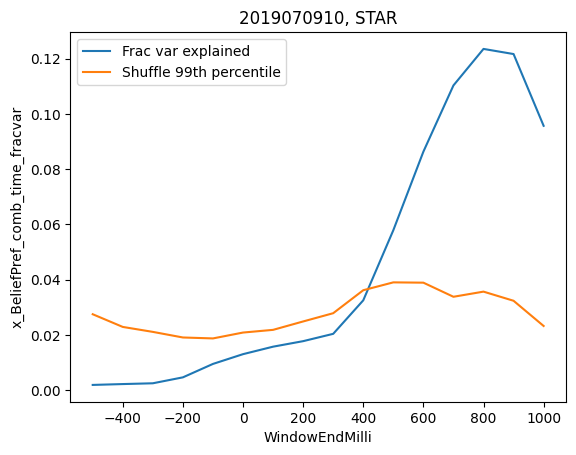

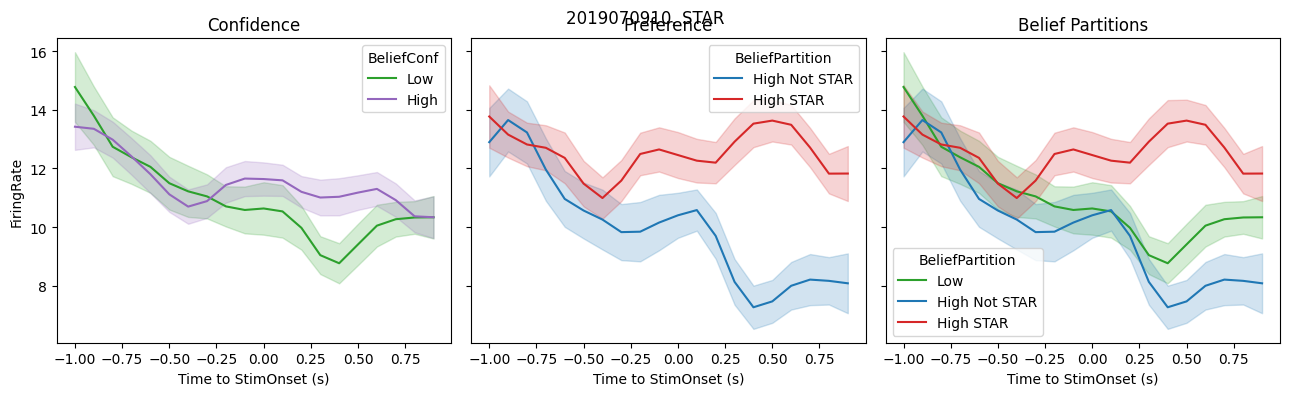

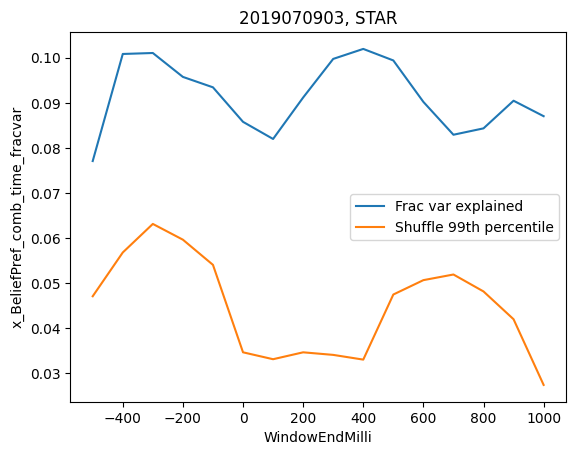

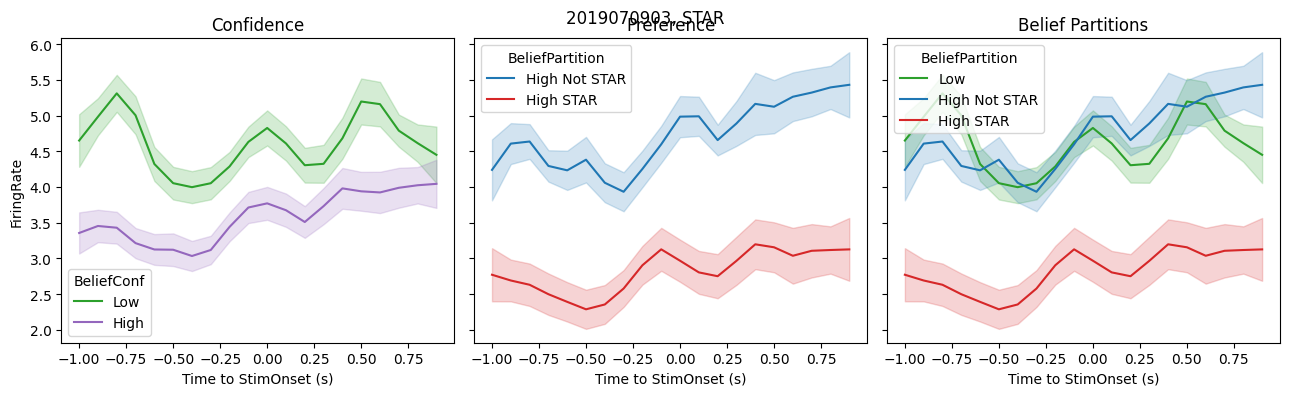

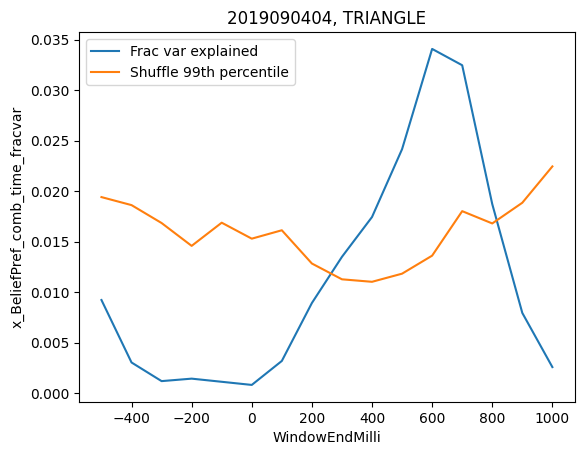

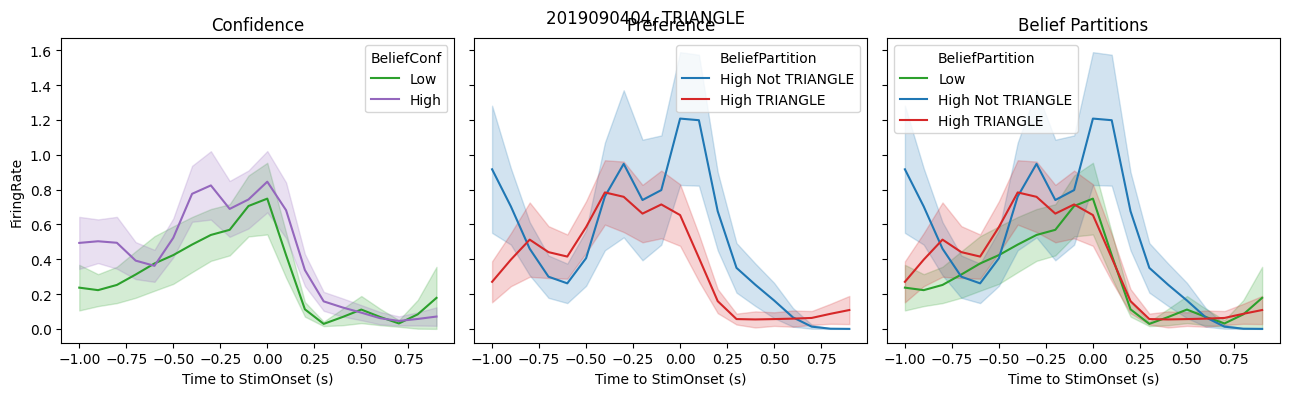

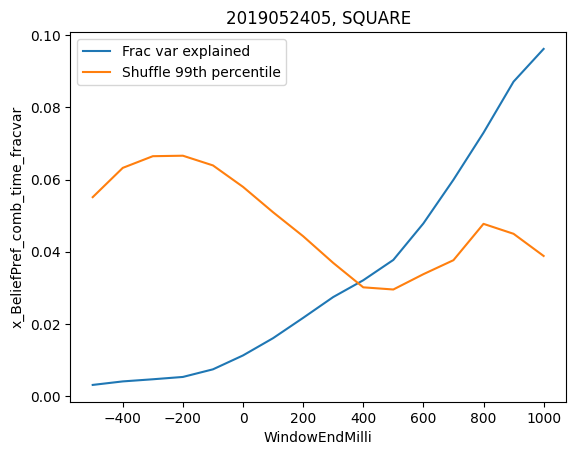

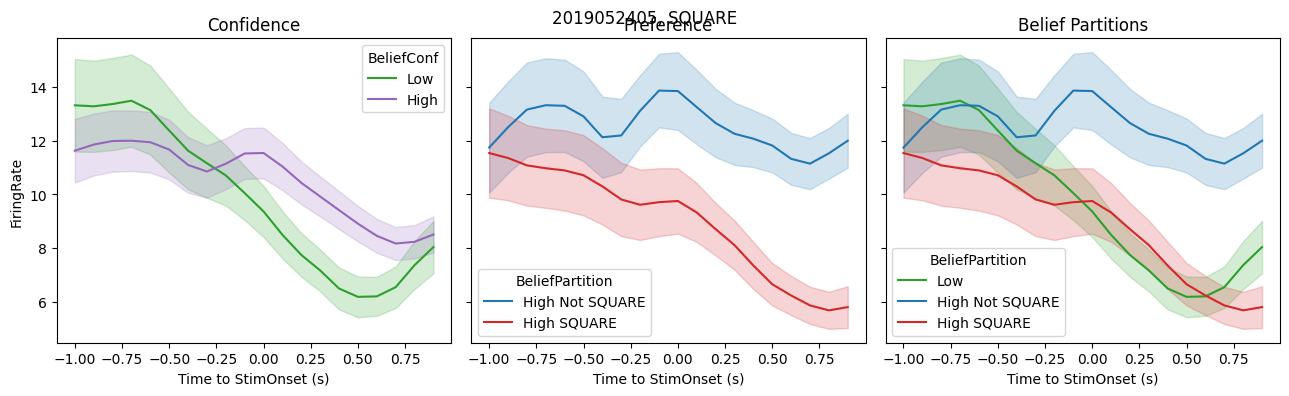

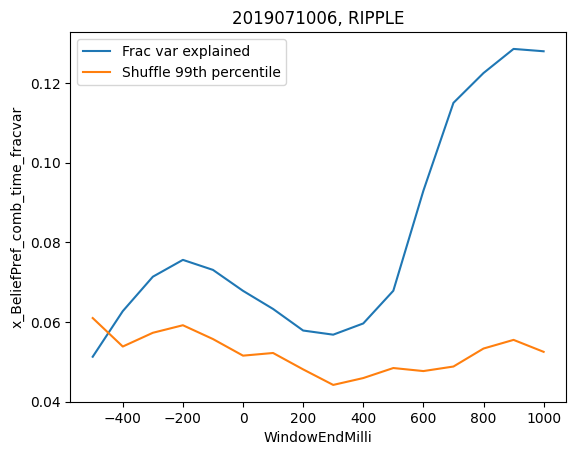

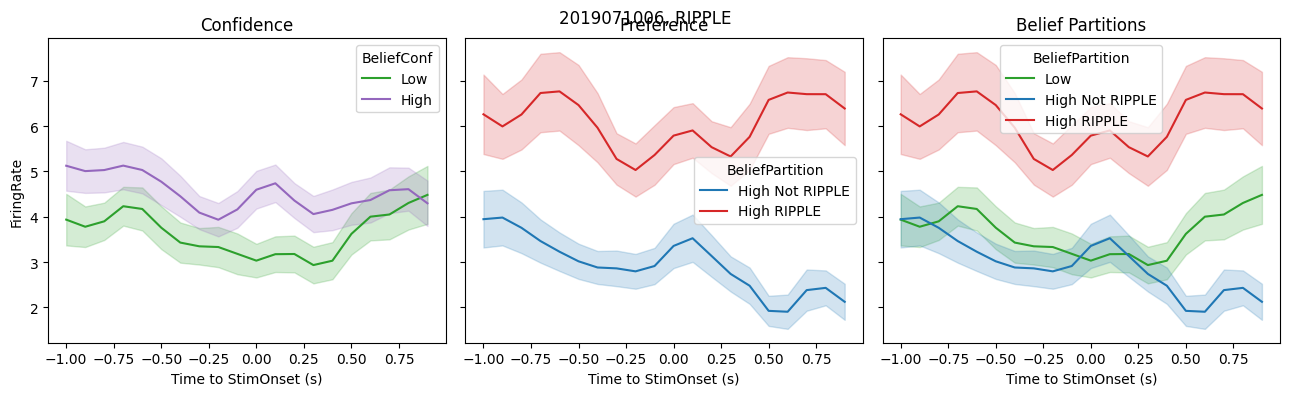

In [6]:
for i, row in max_sig[:5].iterrows():
    unit = row.PseudoUnitID
    feat = row.feat
    sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
    fig, ax = plt.subplots()
    sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=ax, label="Frac var explained")
    sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=ax, label="Shuffle 99th percentile")
    ax.set_title(f"{unit}, {feat}")
    fig, _ = visualization_utils.plot_belief_partition_psth(unit, feat, args)    
    fig.suptitle(f"{unit}, {feat}")

### What about examples with high frac variance explained?

In [17]:
max_frac = res.groupby(["PseudoUnitID", "feat"]).x_BeliefPref_comb_time_fracvar.max().reset_index(name="max_frac")
max_frac = max_frac.sort_values(by="max_frac", ascending=False)

In [18]:
max_frac

PseudoUnitID      feat  max_frac
3831    2018090712    SQUARE  0.158317
1996    2018080803  POLKADOT  0.158102
4504    2018091907     GREEN  0.136160
4576    2018091921      STAR  0.112250
4646    2018092005    SQUARE  0.109032
...            ...       ...       ...
5218    2018092601  TRIANGLE       NaN
5479    2018100106     GREEN       NaN
5480    2018100106   MAGENTA       NaN
5481    2018100106  POLKADOT       NaN
5728    2018100412   MAGENTA       NaN

[6149 rows x 3 columns]

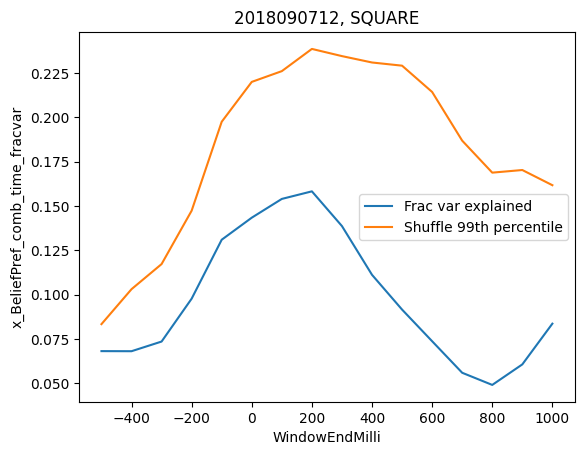

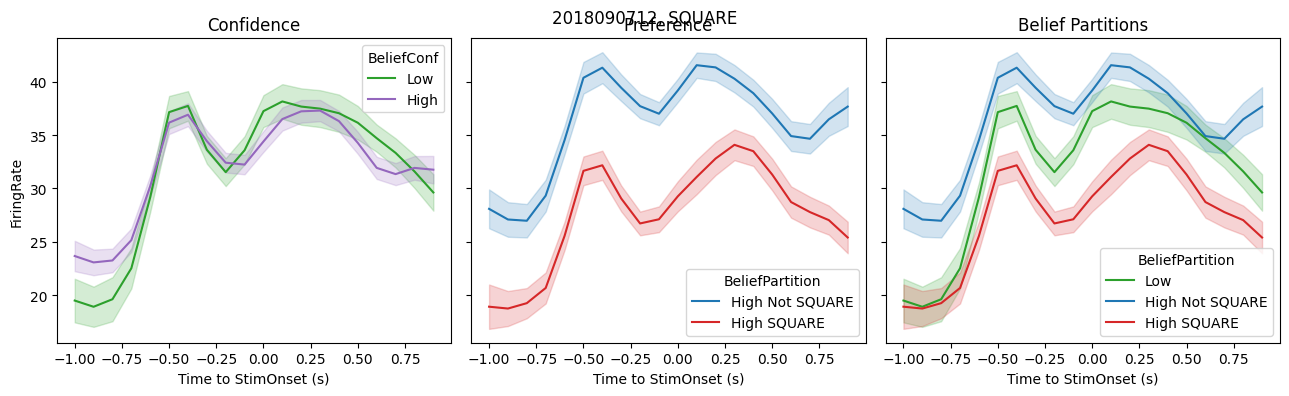

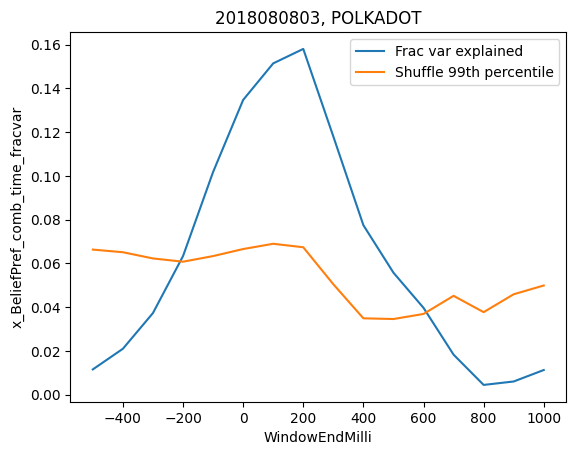

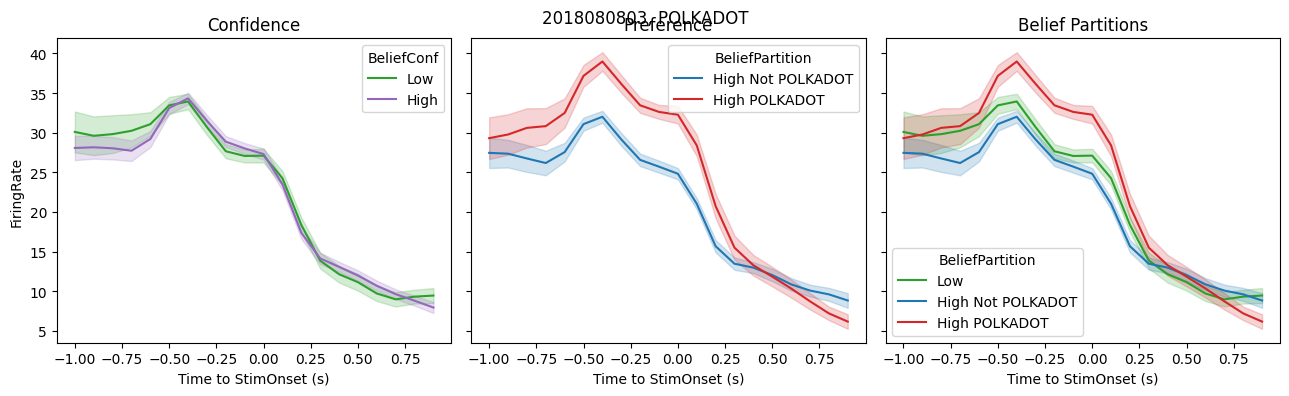

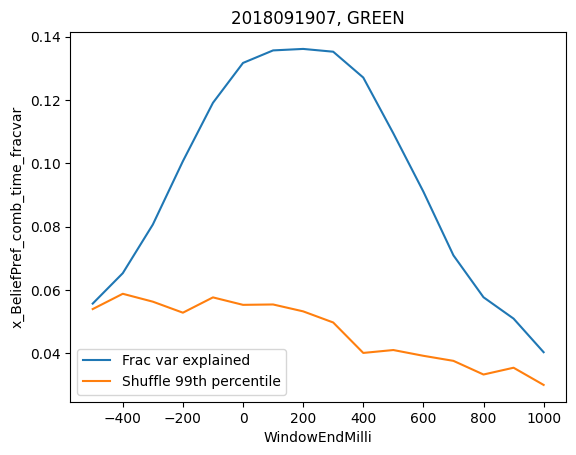

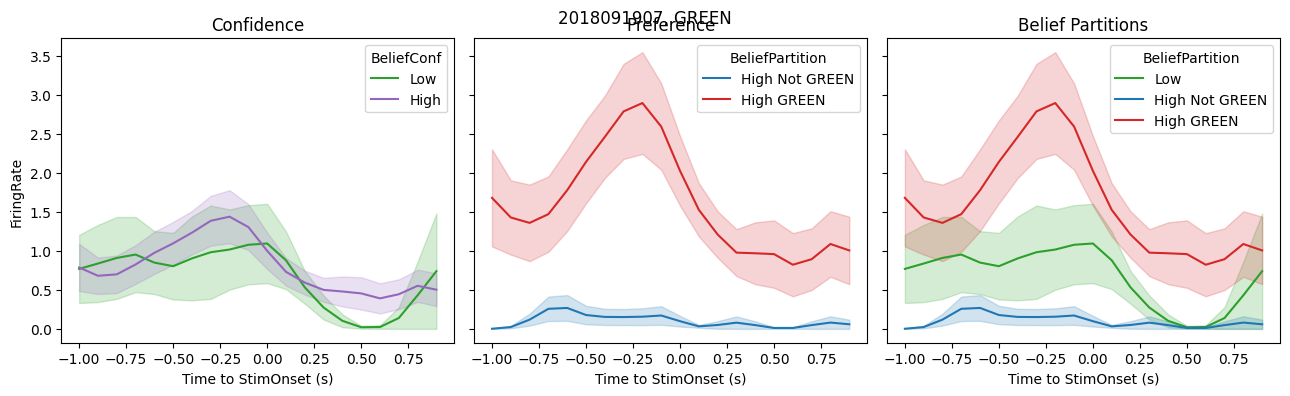

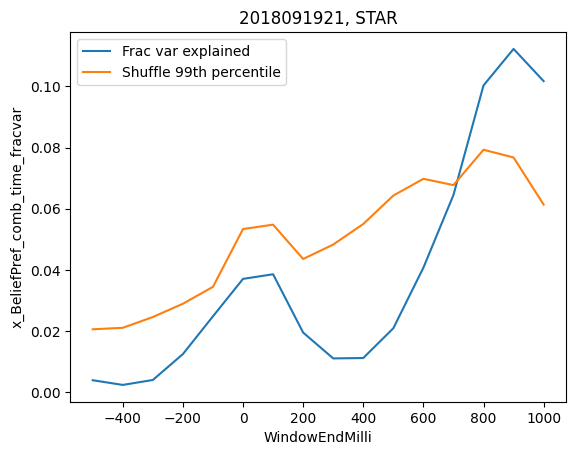

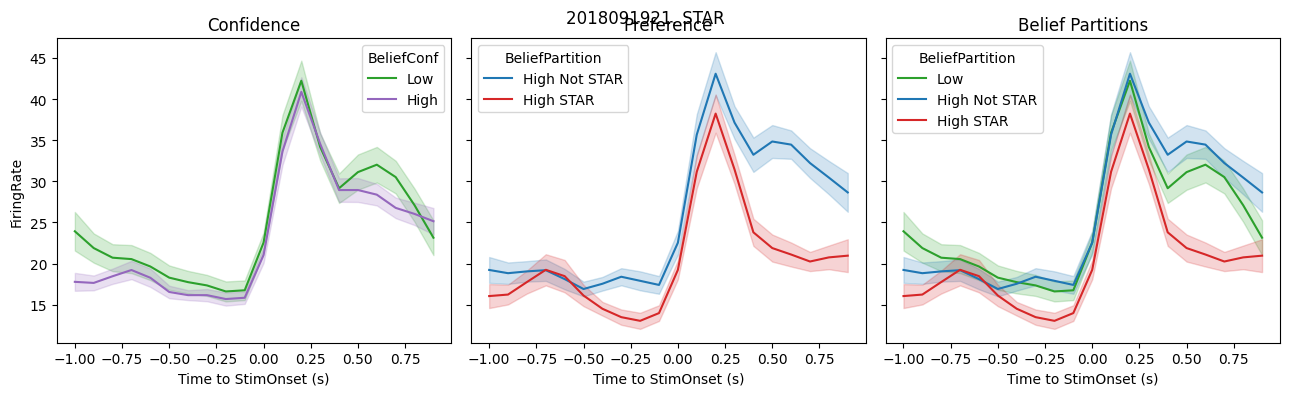

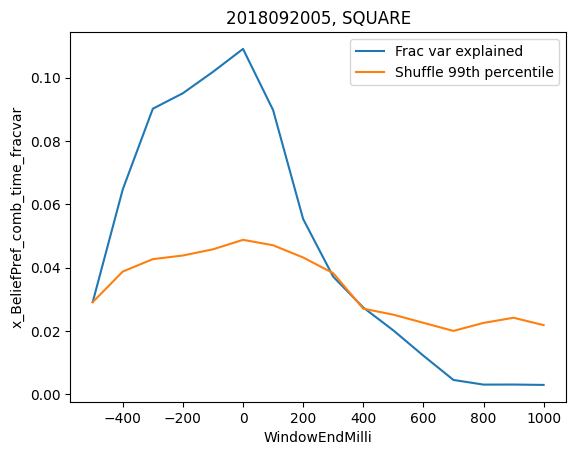

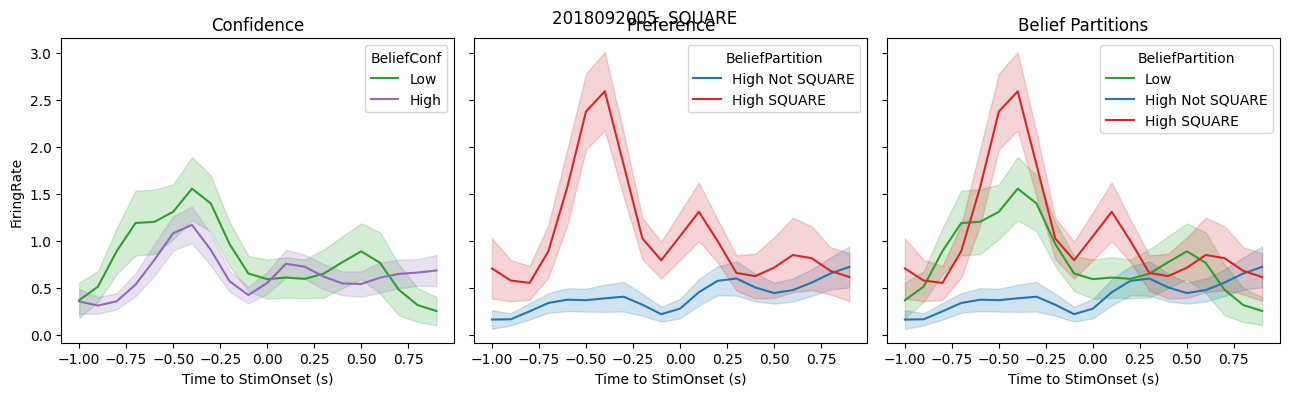

In [19]:
for i, row in max_frac[:5].iterrows():
    unit = row.PseudoUnitID
    feat = row.feat
    sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
    fig, ax = plt.subplots()
    sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=ax, label="Frac var explained")
    sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=ax, label="Shuffle 99th percentile")
    ax.set_title(f"{unit}, {feat}")
    fig, _ = visualization_utils.plot_belief_partition_psth(unit, feat, args)    
    fig.suptitle(f"{unit}, {feat}")

### Wonder what PSTHs of units look like where they're selective for two features

In [22]:
sig_feats = res[(res.sig_ratio > 1.5) & (res.x_BeliefPref_comb_time_fracvar > 0.01)].groupby("PseudoUnitID").feat.unique().reset_index(name="sig_feats")
sig_feats["n_sig_feats"] = sig_feats.sig_feats.apply(lambda x: len(x))
sig_feats = sig_feats.sort_values(by="n_sig_feats", ascending=False)

In [23]:
sig_feats

PseudoUnitID                    sig_feats  n_sig_feats
48       2018080336       [STAR, CYAN, POLKADOT]            3
55       2018080625     [SQUARE, GREEN, MAGENTA]            3
47       2018080330     [CIRCLE, STAR, TRIANGLE]            3
35       2018080228  [CIRCLE, TRIANGLE, MAGENTA]            3
185      2018100514           [POLKADOT, RIPPLE]            2
..              ...                          ...          ...
76       2018081716                      [GREEN]            1
77       2018081725                       [STAR]            1
78       2018082005                     [SQUARE]            1
79       2018082007                    [MAGENTA]            1
196  20180725000137                     [YELLOW]            1

[197 rows x 3 columns]

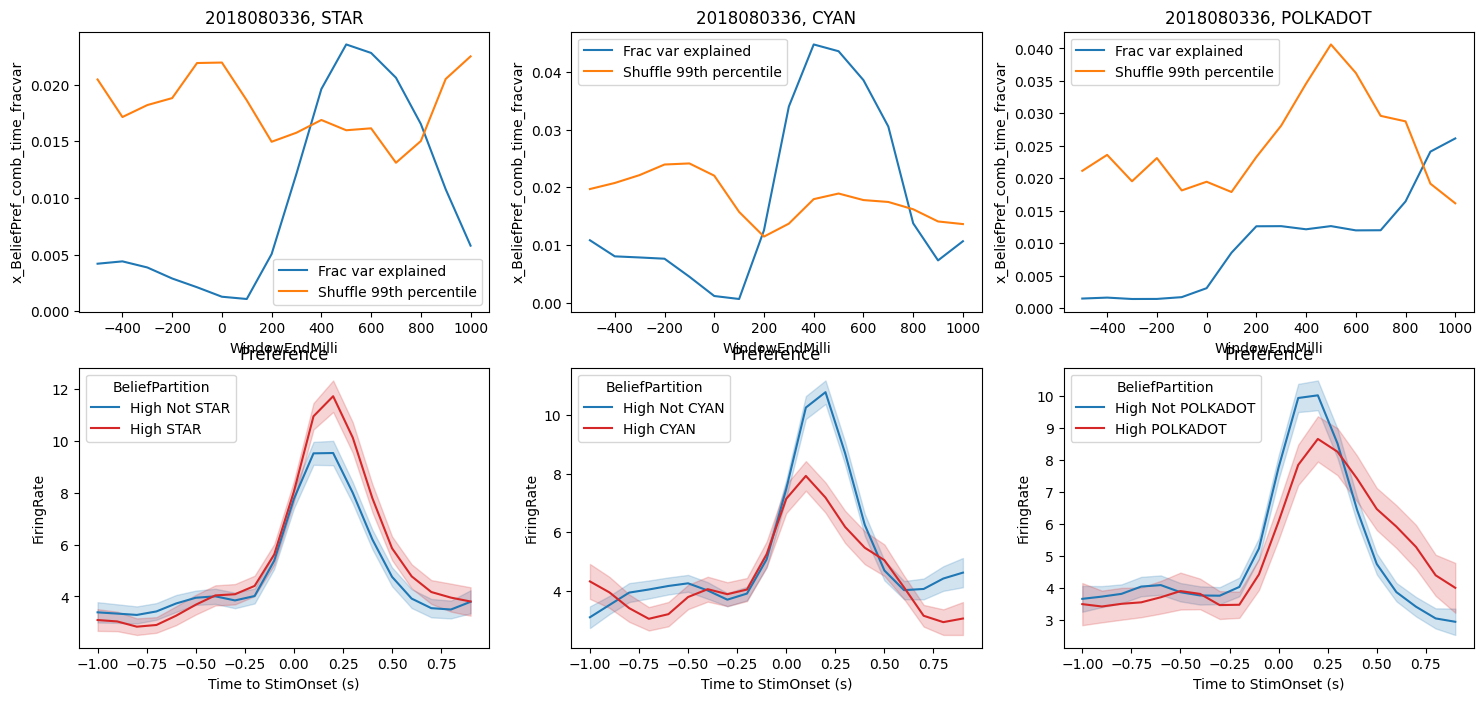

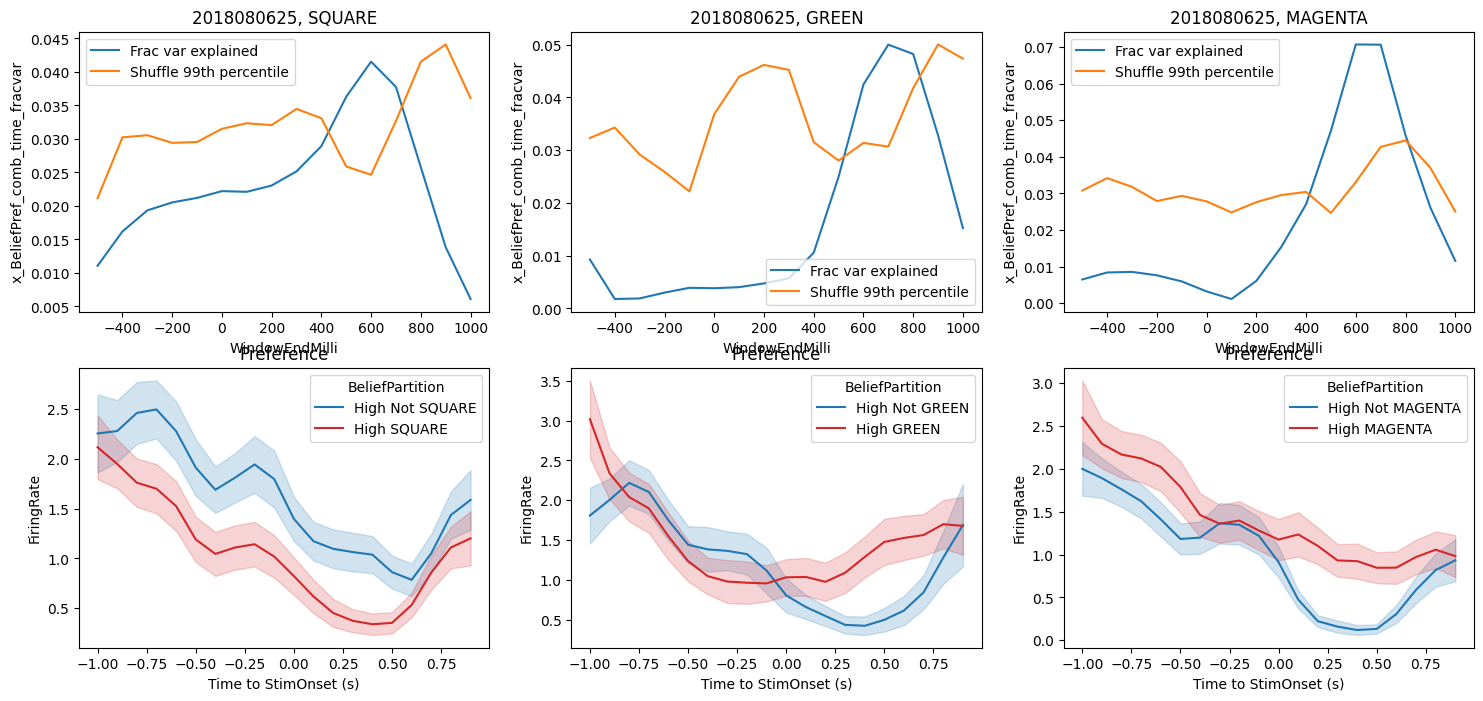

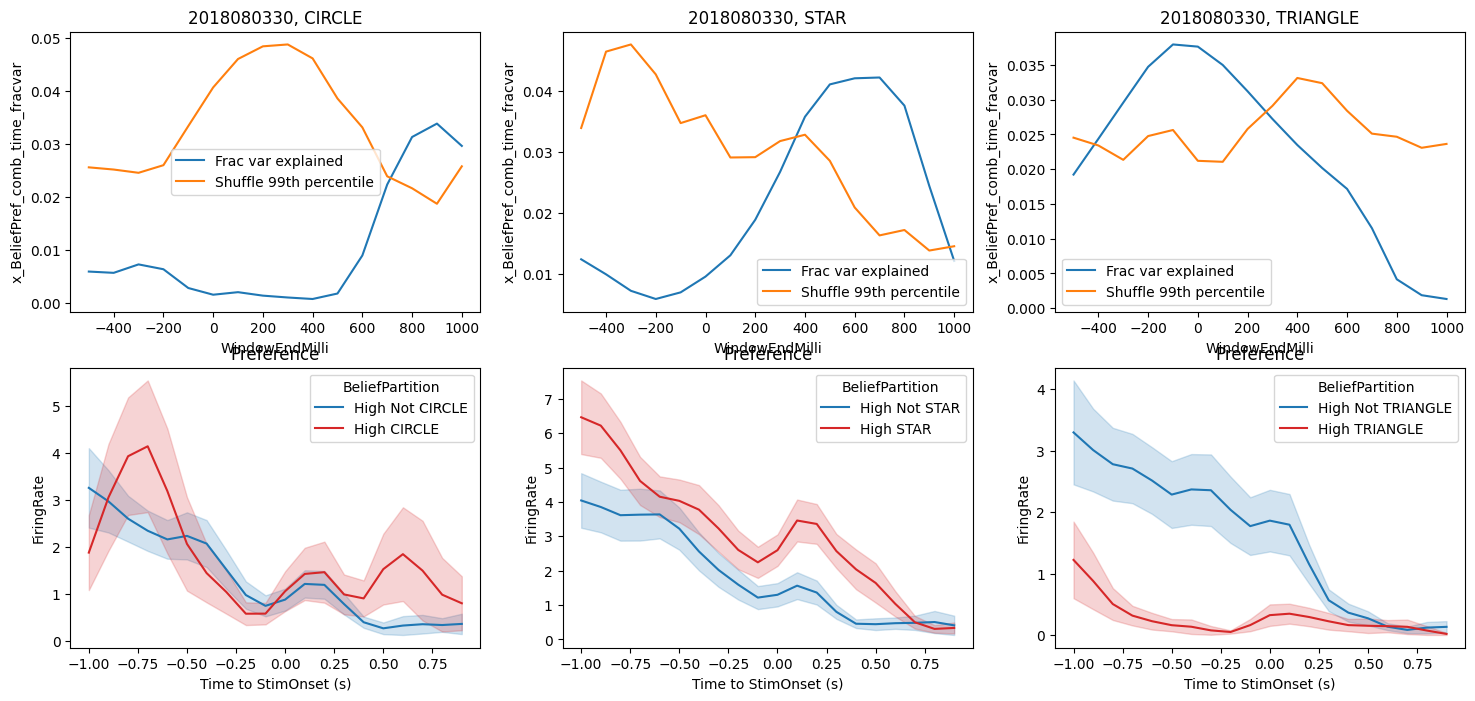

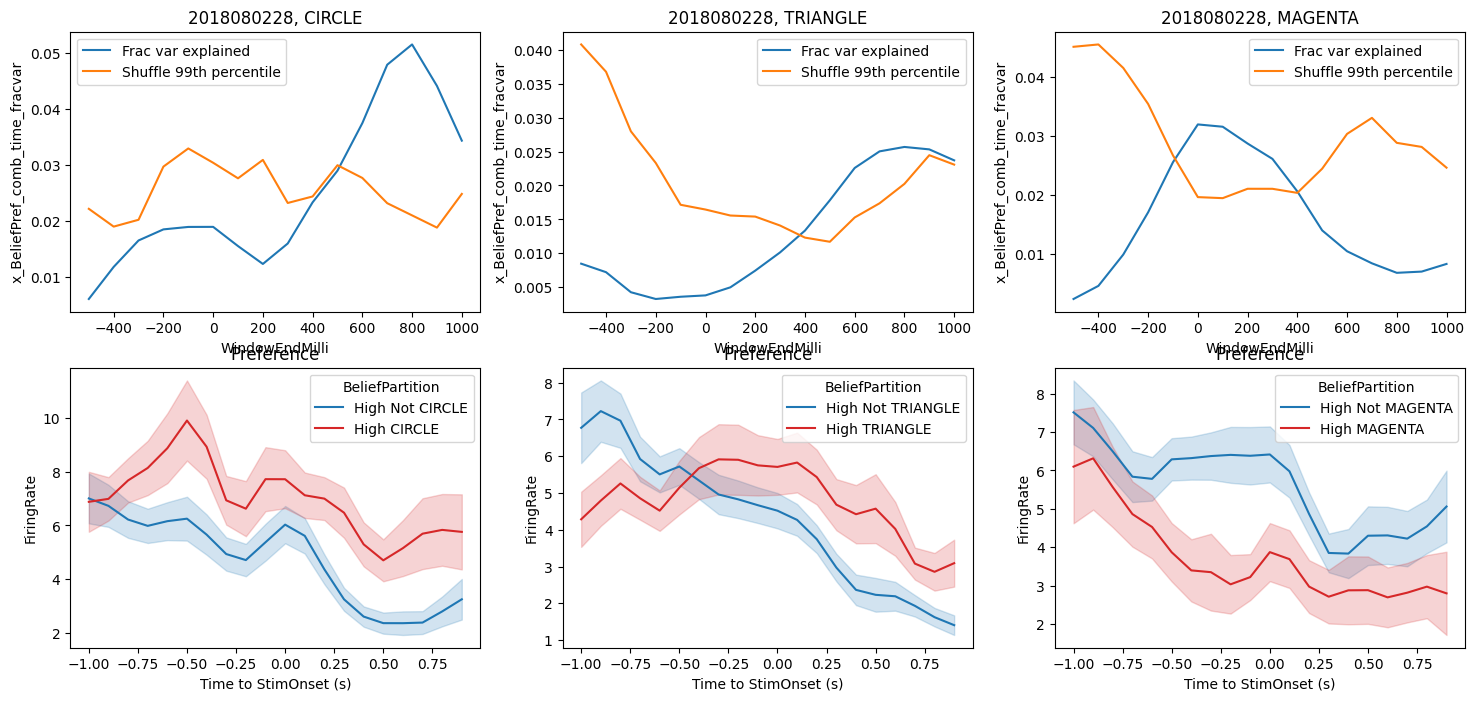

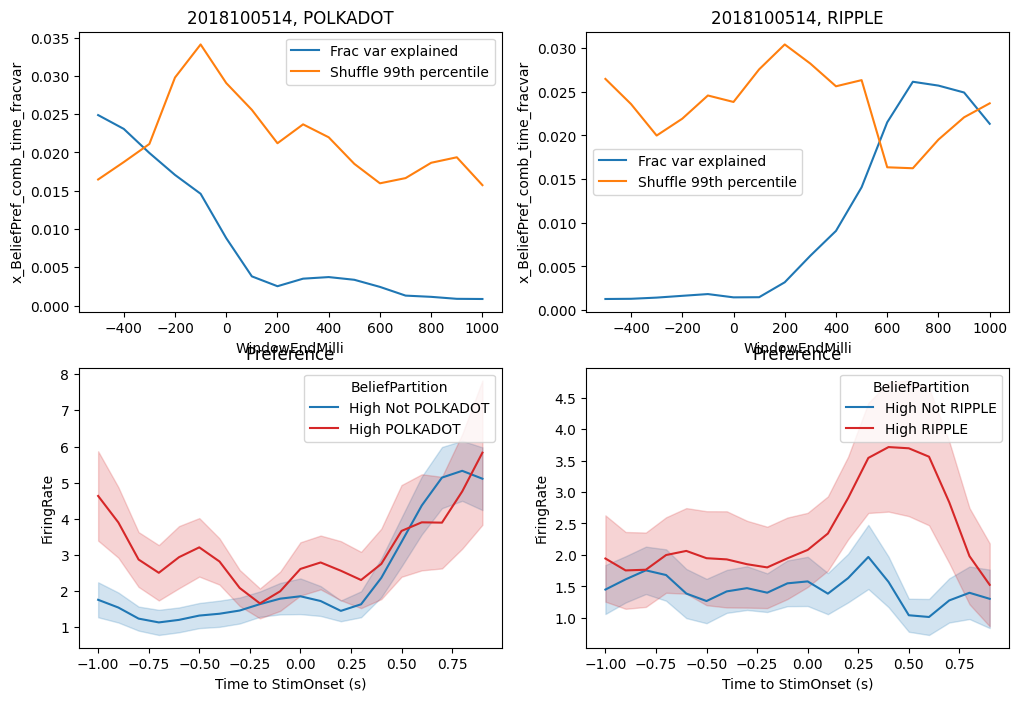

In [24]:
for i, row in sig_feats[:5].iterrows():
    unit = row.PseudoUnitID
    feats = row.sig_feats
    fig, axs = plt.subplots(2, len(feats), figsize=(len(feats) * 6, 8), squeeze=False)
    for feat_idx, feat in enumerate(feats):
        sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
        sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=axs[0, feat_idx], label="Frac var explained")
        sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=axs[0, feat_idx], label="Shuffle 99th percentile")
        axs[0, feat_idx].set_title(f"{unit}, {feat}")


        args.feat = feat
        session = int(unit / 100)
        beh, frs = load_data(session, args, return_merged=False)
        frs = frs[frs.PseudoUnitID == unit]

        sub_beh = beh[beh.BeliefPartition.isin([f"High {args.feat}", f"High Not {args.feat}"])]
        order = [f"High Not {args.feat}", f"High {args.feat}"]
        colors = ["tab:blue", "tab:red"]

        ax = axs[1, feat_idx]
        sns.lineplot(pd.merge(frs, sub_beh, on="TrialNumber"), x="Time", y="FiringRate", errorbar="se", hue="BeliefPartition", hue_order=order, palette=colors, ax=ax)
        ax.set_xlabel(f"Time to {args.trial_event} (s)")
        ax.set_title("Preference")

### What about examples where both preference and confidence frac var explained are high in the same time bin?

In [11]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "SA"
args.trial_event = "FeedbackOnsetLong"
res = io_utils.read_anova_good_units(args, "all", "")
res["pref_sig_ratio"] = res.x_BeliefPref_comb_time_fracvar / res.BeliefPref_99th
res["conf_sig_ratio"] = res.x_BeliefConf_comb_time_fracvar / res.BeliefConf_99th

In [14]:
sub_res = res[(res.pref_sig_ratio > 2) & (res.conf_sig_ratio > 2)]
max_frac = sub_res.groupby(["PseudoUnitID", "feat"]).max().reset_index()
max_frac = max_frac.sort_values(by=["x_BeliefPref_comb_time_fracvar", "x_BeliefConf_comb_time_fracvar"], ascending=False)


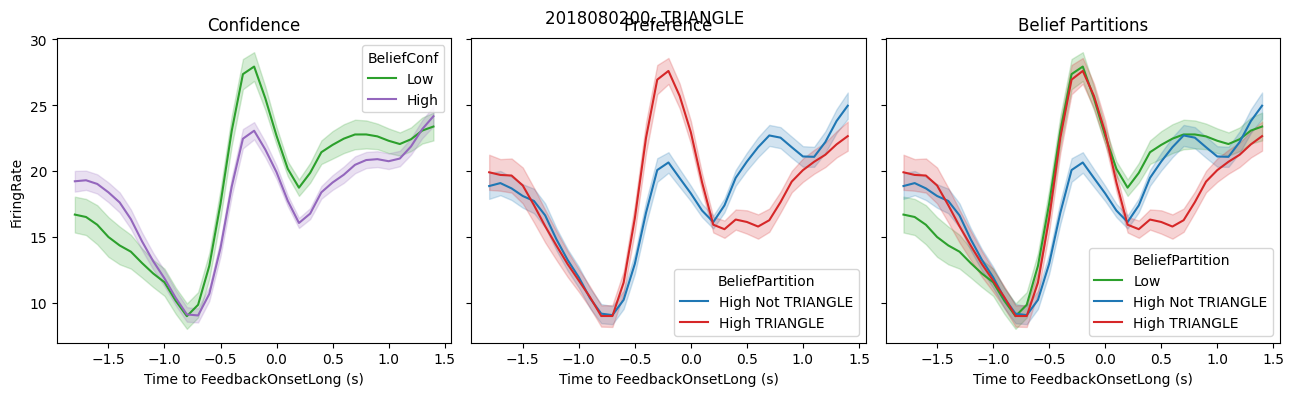

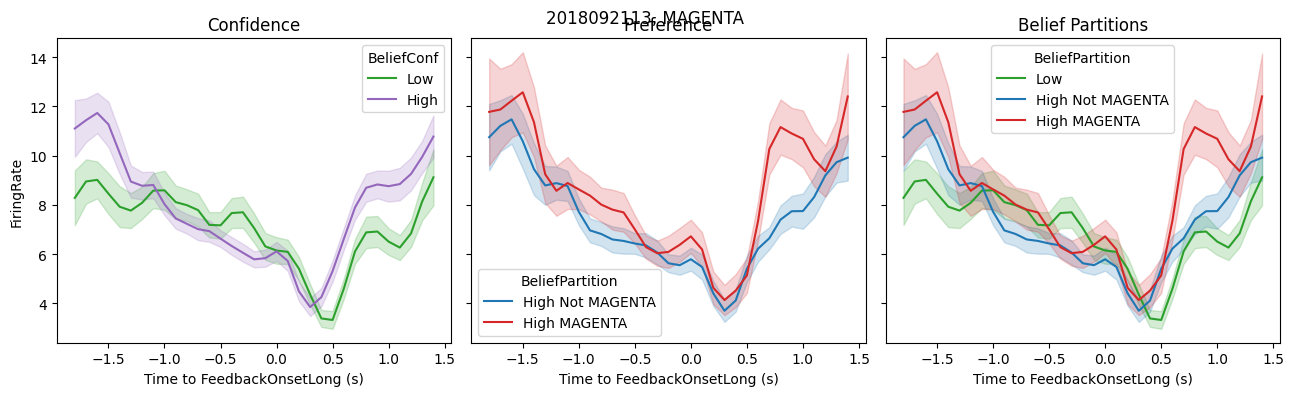

In [15]:
for i, row in max_frac[:5].iterrows():
    unit = row.PseudoUnitID
    feat = row.feat
    # sub_res = res[(res.PseudoUnitID == unit) & (res.feat == feat)][["x_BeliefPref_comb_time_fracvar", "PseudoUnitID", "feat", "WindowEndMilli", "BeliefPref_99th"]]
    # fig, ax = plt.subplots()
    # sns.lineplot(sub_res, x="WindowEndMilli", y="x_BeliefPref_comb_time_fracvar", ax=ax, label="Frac var explained")
    # sns.lineplot(sub_res, x="WindowEndMilli", y="BeliefPref_99th", ax=ax, label="Shuffle 99th percentile")
    # ax.set_title(f"{unit}, {feat}")
    fig, _ = visualization_utils.plot_belief_partition_psth(unit, feat, args)    
    fig.suptitle(f"{unit}, {feat}")

### For some feature, plot hist of frac var explained, sorted by peak:

In [3]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.subject = "SA"
args.trial_event = "FeedbackOnsetLong"
res = io_utils.read_anova_good_units(args, "all", "")

feat = "SQUARE"
res = res[res.feat == feat]
res = res[~res.x_BeliefPref_comb_time_fracvar.isna()]

In [10]:
res[res.PseudoUnitID == 2018090623].WindowEndMilli.unique()

array([-1300, -1200, -1100, -1000,  -900,  -800,  -700,  -600,   200,
         300,   400,   500,   600,   700,   800,   900,  1000,  1100,
        1200,  1300,  1400,  1500])

<Axes: xlabel='WindowEndMilli', ylabel='PseudoUnitID'>

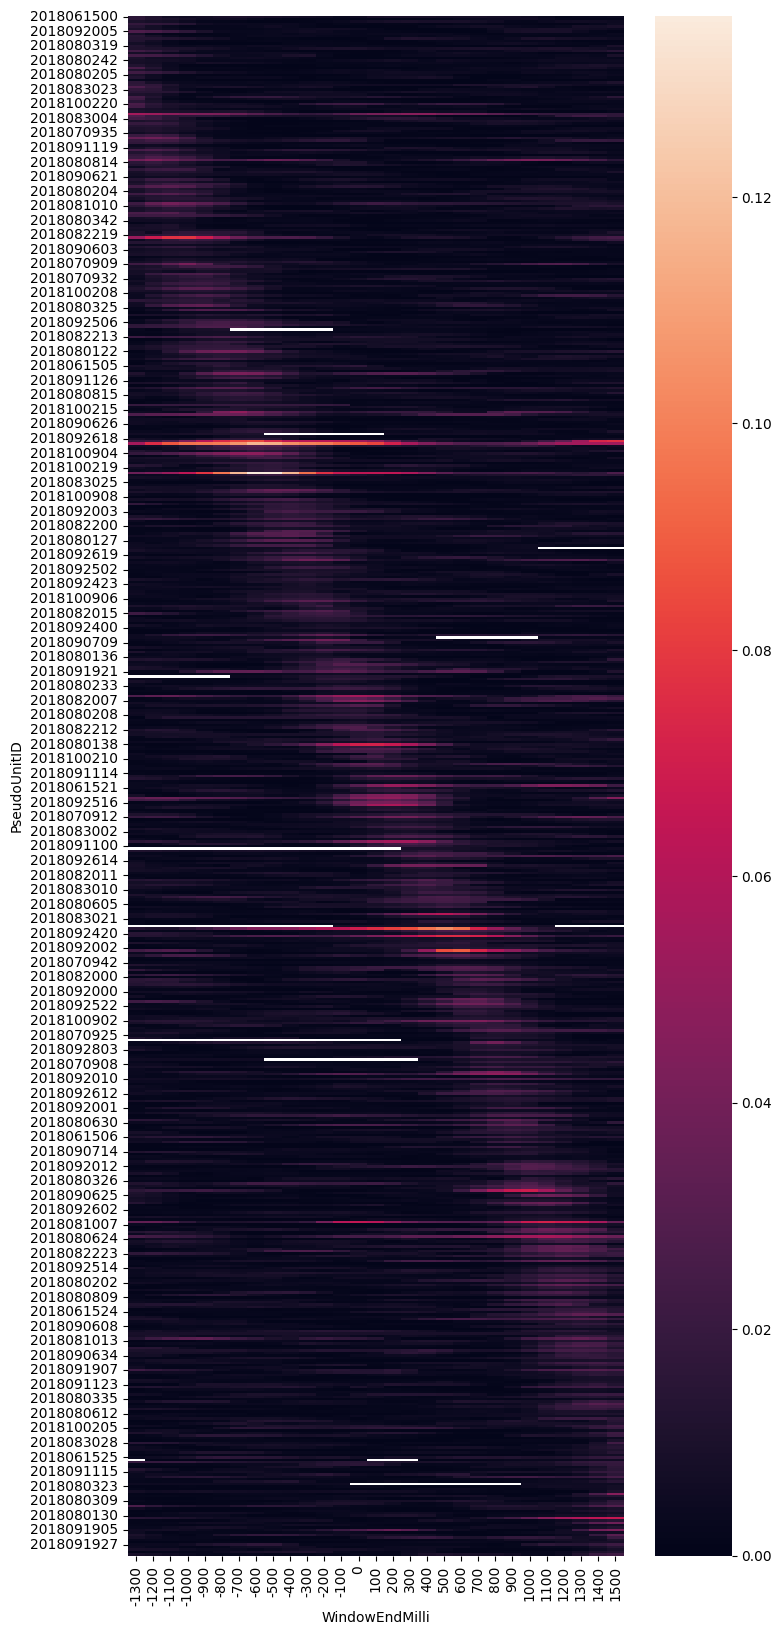

In [7]:
var = "x_BeliefPref_comb_time_fracvar"

def find_peak(group):
    row_idx = group[var].idxmax()
    return group.loc[row_idx].WindowEndMilli

peaks = res.groupby("PseudoUnitID").apply(find_peak).reset_index(name="peak_time")
order = peaks.sort_values(by="peak_time").PseudoUnitID

pivoted = res.pivot(index="PseudoUnitID", columns="WindowEndMilli", values=var)
pivoted = pivoted.loc[order]
fig, ax = plt.subplots(figsize=(8, 20))
sns.heatmap(pivoted, ax=ax)

<Axes: xlabel='WindowEndMilli', ylabel='PseudoUnitID'>

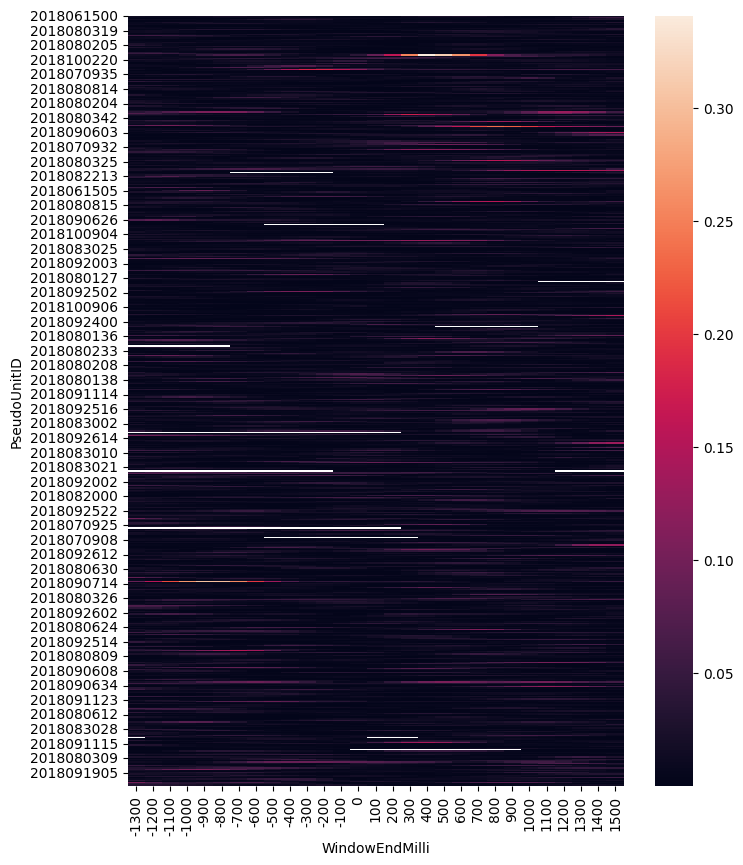

In [47]:
var = "x_BeliefConf_comb_time_fracvar"

pivoted = res.pivot(index="PseudoUnitID", columns="WindowEndMilli", values=var)
pivoted = pivoted.loc[order]
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pivoted, ax=ax)